In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
from icecream import ic
import pandas as pd
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

## MODELS ##
from Models.dataset import  DatasetCelebA_Sketch
from Models.Discriminator_Stage2 import Discriminator as Discriminator_S2
from Models.Generator_Stage2 import Generator as Generator_S2
from Models.Discriminator_Stage3 import Discriminator as Discriminator_S3
from Models.Generator_Stage3 import Generator as Generator_S3
from Models.CVAE_Encoder import Encoder
from Models.CVAE_Decoder import Decoder
from torchvision.models import VGG16_Weights



# ATTRIBUTE TO SKETCH TO FACE

Linking all the stages together

In [48]:
ATTR_DIM = 4
resize =  transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize([64,64])])

def read_images(index, display=1):
    EXCEL_PATH = "E:\Lucru\Dizertatie\Cod\Face_Synthesis\Database\celebA_medium.xlsx"
    DATASET_PATH = "E:\Lucru\Dizertatie\Cod\Face_Synthesis\Database\medium_dataset\\"
    SKETCH_DATASET_PATH = "E:\Lucru\Dizertatie\Cod\Face_Synthesis\Database\medium_dataset_sketch\\"

    resize =  transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize([64,64])])

    transf = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize([64,64]),
                                transforms.ToTensor()])

    transf_sketch = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize([64,64]),
                                transforms.ToTensor()])

    df = pd.read_excel(EXCEL_PATH)
    data = df["image_id"]
    labels = df.iloc[:, 1:(ATTR_DIM + 1)]
    # labels = df["Male"]

    # index = 17

    # 25 - nice female
    # 31 - male

    img = cv2.imread(DATASET_PATH + data[index])
    # img = cv2.imread('E:\Lucru\Dizertatie\Cod\Image-to-Sketch\source\\Vaman_Teodora.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    sketch_img = cv2.imread(SKETCH_DATASET_PATH + data[index])
    # sketch_img = cv2.imread('E:\Lucru\Dizertatie\Cod\Image-to-Sketch\destination\\Vaman_Teodora.jpg')
    sketch_img = cv2.cvtColor(sketch_img, cv2.COLOR_BGR2RGB)

    batch_data = img
    batch_data = transf(batch_data)

    batch_sketch_data = sketch_img
    batch_sketch_data = transf_sketch(batch_sketch_data)

    batch_labels = labels.iloc[index].values
    pil_img = resize(img)
    pil_img_sketch = resize(sketch_img)
    if display == 1 :
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.title("Imagine Originala")
        plt.imshow(np.asarray(pil_img))
        plt.subplot(1, 2, 2)
        plt.imshow(np.asarray(pil_img_sketch))
        plt.title("Imagine Schita reala")

    # print(f"Attributes [Gender Smiling Eyeglasses No_Beard] = {labels.iloc[index].values}")
    # Gender Smiling Eyeglasses No_Beard
    return batch_sketch_data, batch_data, batch_labels

# sketch_img, img, labels = read_images(7)

In [49]:
## DEFINE THE MODELS
encoder = Encoder(attribute_number=ATTR_DIM)
decoder = Decoder(attribute_number=ATTR_DIM)
retea_G3 = Generator_S3(img_size=3, attribute_number=ATTR_DIM)
retea_D3 = Discriminator_S3(64, attribute_number=ATTR_DIM)
retea_G2 = Generator_S2(attribute_number=ATTR_DIM)
retea_D2 = Discriminator_S2(img_size=64, attribute_number=ATTR_DIM)
retea_G3.cuda()
retea_D3.cuda()
retea_G2.cuda()
retea_D2.cuda()
encoder.cuda()
decoder.cuda()
encoder.eval()
decoder.eval()
retea_G3.eval()
retea_D3.eval()
retea_G2.eval()
retea_D2.eval()


# decoder.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Stage1_Attr2Sketch\\retea_Decoder.pt'))
# encoder.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Stage1_Attr2Sketch\\retea_Encoder.pt'))

decoder.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Attr2Sketch2Face\checkpoints\\retea_Decoder_10epoci_medium2.pt'))
encoder.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Attr2Sketch2Face\checkpoints\\retea_Encoder_10epoci_medium2.pt'))

retea_D2.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Attr2Sketch2Face\checkpoints\\retea_D_Stage2_6epoci_fearless_lion.pt'))
retea_G2.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Attr2Sketch2Face\checkpoints\\retea_G_Stage2_6epoci_fearless_lion.pt'))

# retea_D3.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Attr2Sketch2Face\checkpoints\\retea_D_stage3_lossMin.pt')) #retea_D_stage3_lossMin
# retea_G3.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Attr2Sketch2Face\checkpoints\\retea_G_stage3_lossMin.pt'))

retea_D3.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Attr2Sketch2Face\\20epoci\\A2F_retea_D_stage3.pt')) #retea_D_stage3_lossMin
retea_G3.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Attr2Sketch2Face\\20epoci\\A2F_retea_G_stage3.pt'))

Using cache found in C:\Users\Teodora/.cache\torch\hub\pytorch_vision_v0.10.0


<All keys matched successfully>

In [53]:
DEVICE = 'cuda'

def synth_images(attributes, display=1, index=0):
    sketch_img, img, labels = read_images(index, display=0)
    
    esantioane_proba = torch.stack([sketch_img], dim=0)
    etichete_proba = torch.FloatTensor([attributes])

    esantioane_proba = esantioane_proba.to(torch.device(DEVICE))
    etichete_proba = etichete_proba.to(torch.device(DEVICE))
    zgomot_proba = torch.FloatTensor(esantioane_proba.shape[0], 256).normal_(0, 1)
    zgomot_proba  = zgomot_proba.to(torch.device(DEVICE))

    ic(etichete_proba.shape)
    zgomot_embedded, schita_embedded, encode_text = encoder(noise=zgomot_proba, attr_text=etichete_proba, sketch=esantioane_proba, detach_flag=True)
    reconstructed_sketch_images, reconstructed_fake_images = decoder(zgomot_embedded[0], schita_embedded[0], detach_flag=True)

    imagini_generate_Stage2 = retea_G2(reconstructed_sketch_images, encode_text).detach()
    imagini_generate_Stage3 = retea_G3(esantioane_proba, etichete_proba).detach()


    reconstructed_sketch_images = torch.squeeze(reconstructed_fake_images, 0)
    reconstructed_sketch_images = reconstructed_sketch_images.to(torch.device('cpu'))

    reconstructed_fake_images = torch.squeeze(reconstructed_fake_images, 0)
    reconstructed_fake_images = reconstructed_fake_images.to(torch.device('cpu'))

    imagini_generate_Stage2 = torch.squeeze(imagini_generate_Stage2, 0)
    imagini_generate_Stage2 = imagini_generate_Stage2.to(torch.device('cpu'))

    imagini_generate_Stage3 = torch.squeeze(imagini_generate_Stage3, 0)
    imagini_generate_Stage3 = imagini_generate_Stage3.to(torch.device('cpu'))

    # plt.subplot(1, 4, 1)
    # plt.imshow(img)
    # plt.subplot(1, 4, 2)
    # plt.imshow(sketch_img)
    pil_img = resize(img)
    pil_img_sketch = resize(sketch_img)
    print(f"Attributes [Gender Smiling Eyeglasses No_Beard] = {attributes}")
    if display == 1 :
        plt.figure(figsize=(20,60))
        plt.subplot(1, 6, 1)
        plt.title("Imagine Originala")
        plt.imshow(np.asarray(pil_img))
        plt.subplot(1, 6, 2)
        plt.imshow(np.asarray(pil_img_sketch))
        plt.title("Imagine Schita reala")
        plt.subplot(1, 6, 3)
        plt.imshow(np.transpose(reconstructed_sketch_images,(1,2,0)), cmap='gray')
        plt.title("reconstructed_sketch_images")
        plt.subplot(1, 6, 4)
        plt.imshow(np.transpose(reconstructed_fake_images,(1,2,0)), cmap='gray')
        plt.title("reconstructed_fake_images")
        plt.subplot(1, 6, 5)
        plt.imshow(np.transpose(imagini_generate_Stage2,(1,2,0)), cmap='gray')
        plt.title("imagini_generate_Stage2")
        plt.subplot(1, 6, 6)
        plt.imshow(np.transpose(imagini_generate_Stage3,(1,2,0)), cmap='gray')
        plt.title("imagini_generate_Stage3")
        plt.show()

    if display == 4 :
        plt.figure(figsize=(10,15))
        plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(reconstructed_fake_images,(1,2,0)), cmap='gray')
        plt.title("reconstructed_fake_images")
        plt.subplot(1, 3, 2)
        plt.imshow(np.transpose(imagini_generate_Stage2,(1,2,0)), cmap='gray')
        plt.title("imagini_generate_Stage2")
        plt.subplot(1, 3, 3)
        plt.imshow(np.transpose(imagini_generate_Stage3,(1,2,0)), cmap='gray')
        plt.title("imagini_generate_Stage3")
        plt.show()

    if display == 3 :
        plt.figure(figsize=(10,30))
        plt.subplot(1, 3, 1)
        plt.title("Imagine Originala")
        plt.imshow(np.asarray(pil_img))
        plt.subplot(1, 3, 2)
        plt.imshow(np.asarray(pil_img_sketch))
        plt.title("Imagine Schita reala")
        plt.subplot(1, 3, 3)
        plt.imshow(np.transpose(imagini_generate_Stage3,(1,2,0)), cmap='gray')
        plt.title(f"Imagine Etapa 3 \n Atribute = {attributes}")
        plt.show()

    if display == 2:
        plt.figure(figsize=(10,40))
        plt.subplot(1, 2, 2)
        plt.imshow(np.transpose(imagini_generate_Stage2,(1,2,0)), cmap='gray')
        plt.title(f"Imagini Generate Etapa2 \n Atribute = {attributes}")
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(reconstructed_sketch_images,(1,2,0)), cmap='gray')
        plt.title(f"Imagini Generate Etapa1, provenite de la zgomot \n Atribute = {attributes}")
        plt.show()

    if display == 0 :
        plt.figure()
        plt.imshow(np.transpose(imagini_generate_Stage3,(1,2,0)), cmap='gray')
        plt.title(f"Attributes [Gender Smiling Eyeglasses No_Beard] = {attributes}")
        plt.show()


    sketch = np.transpose(reconstructed_sketch_images,(1,2,0))
    noise_img = np.transpose(reconstructed_fake_images,(1,2,0))


# s,n = synth_images([1,1,1,1])
# synth_images([1,1,0,1], index=25)

In [56]:
# index cu rezultate frumoase: 25(femeie), 7(barbat) 472(bărbat)
synth_images([0,0,0,1], index=3569, display=1)
synth_images([1,0,0,1], index=1522, display=1)

# synth_images([0,0,0,0], index=25, display=4)
# synth_images([1,0,0,0], index=25, display=4)

# synth_images([0,1,0,1], index=25, display=4)
# synth_images([1,1,0,1], index=25, display=4)

# synth_images([0,1,1,1], index=25, display=4)
# synth_images([1,1,1,1], index=25, display=4)


Attributes [Gender Smiling Eyeglasses No_Beard] = [0, 0, 0, 0]


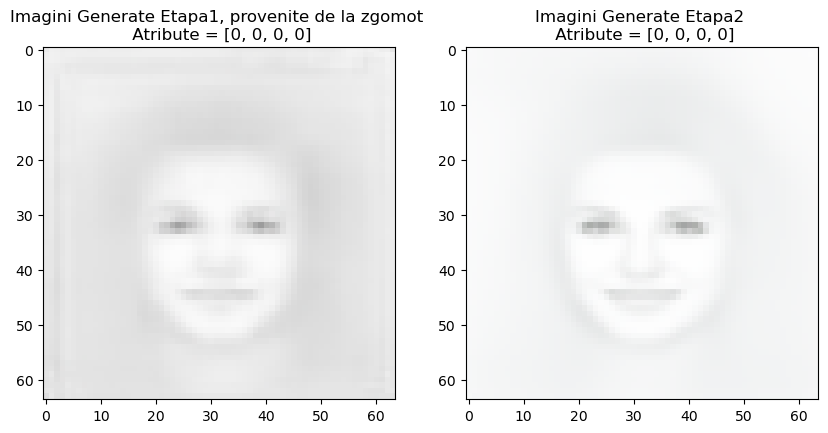

Attributes [Gender Smiling Eyeglasses No_Beard] = [1, 0, 0, 0]


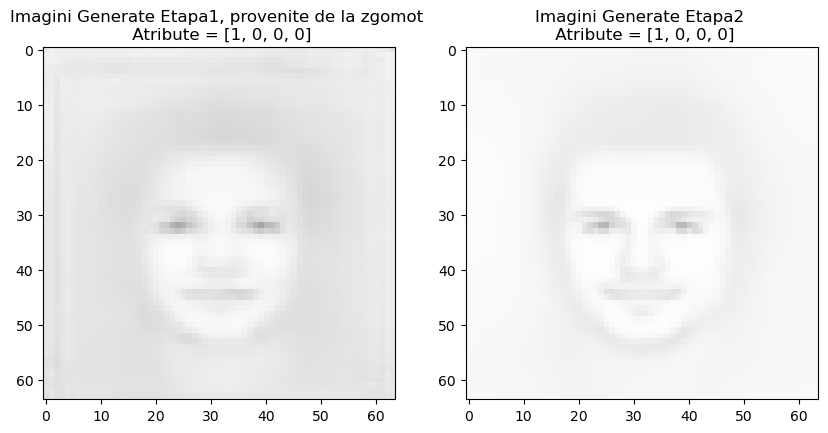

Attributes [Gender Smiling Eyeglasses No_Beard] = [0.2, 0, 0, 0]


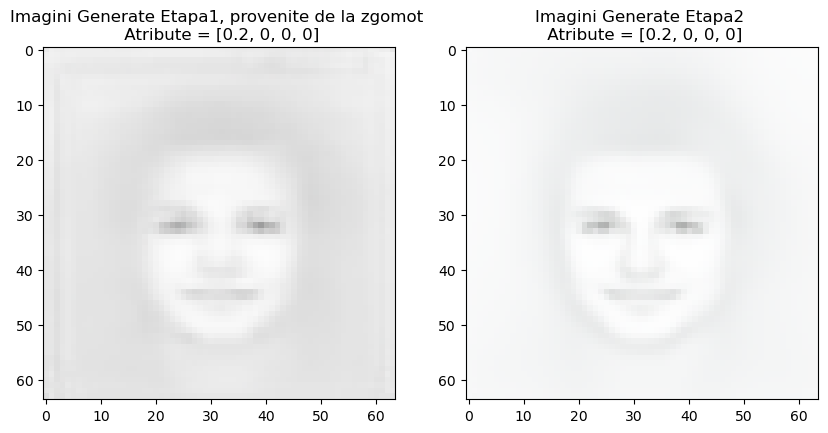

0

In [66]:
synth_images([0,0,0,0], index=7, display=2)
synth_images([1,0,0,0], index=7, display=2)
synth_images([0.2,0,0,0], index=7, display=2)

# synth_images([0,1,0,0], index=2, display=2)
# synth_images([1,1,0,0], index=2, display=2)
# synth_images([0,0,0,1], index=2, display=2)
# synth_images([1,0,0,1], index=2, display=2)




# Random Face Generator

Attributes [Gender Smiling Eyeglasses No_Beard] = [0, 0, 0, 0]


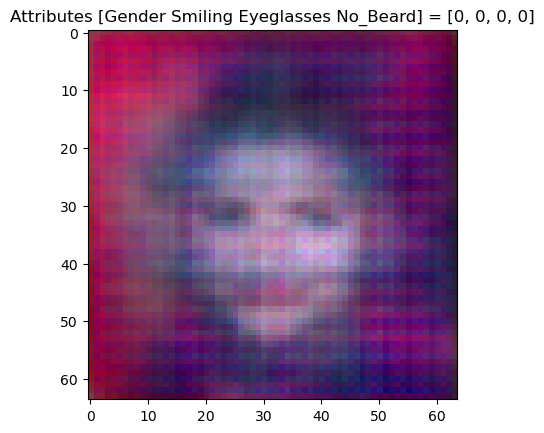

In [6]:

def random_image():
    random_index = random.randint(0, 80000)
    synth_images([0,0,0,0], index=random_index, display=0)

random_image()
